In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from datetime import datetime
import os 

In [2]:
hadoop_log_dir = './hadooplogs/hadooplogs_jetstream'




hadoop_files = [ os.path.join(hadoop_log_dir, f) for f in os.listdir(hadoop_log_dir) if os.path.isfile(os.path.join(hadoop_log_dir, f)) and 'terasort' in f ]




In [3]:
# Function to parse individual Hadoop TeraSort log
def parse_hadoop_terasort_log(file_path):
    metrics = {}
    start_time = None
    end_time = None

    kv_pattern = re.compile(r"^\s+([^:]+):\s+([\d]+)")
    reduce_shuffle_pattern = re.compile(r"Reduce shuffle bytes=(\d+)")
    bytes_read_pattern = re.compile(r"HDFS: Number of bytes read=(\d+)")
    bytes_written_pattern = re.compile(r"HDFS: Number of bytes written=(\d+)")
    cpu_time_pattern = re.compile(r"CPU time spent \(ms\)=(\d+)")
    vcore_ms_pattern = re.compile(r"Total vcore-milliseconds taken by all map tasks=(\d+)")
    killed_maps_pattern = re.compile(r"Killed map tasks=(\d+)")
    phys_mem_snapshot_pattern = re.compile(r"Physical memory \(bytes\) snapshot=(\d+)")

    with open(file_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if "terasort.TeraSort: starting" in line and not start_time:
            try:
                start_time = datetime.strptime(line[:23], "%Y-%m-%d %H:%M:%S,%f")
            except:
                pass
        if "terasort.TeraSort: done" in line:
            try:
                end_time = datetime.strptime(line[:23], "%Y-%m-%d %H:%M:%S,%f")
            except:
                pass

        kv_match = kv_pattern.match(line)
        if kv_match:
            key, value = kv_match.groups()
            metrics[key.strip()] = int(value.strip())

        for pattern, label in [
            (reduce_shuffle_pattern, "reduce_shuffle_bytes"),
            (bytes_read_pattern, "hdfs_bytes_read"),
            (bytes_written_pattern, "hdfs_bytes_written"),
            (cpu_time_pattern, "cpu_time_ms"),
            (vcore_ms_pattern, "vcore_ms"),
            (killed_maps_pattern, "killed_maps"),
            (phys_mem_snapshot_pattern, "phys_mem_bytes"),
        ]:
            match = pattern.search(line)
            if match:
                metrics[label] = int(match.group(1))

    if start_time and end_time:
        metrics['wall_time_sec'] = (end_time - start_time).total_seconds()
    else:
        metrics['wall_time_sec'] = None

    return metrics

In [4]:
# Extract all metrics
hadoop_results = []

for file_path in hadoop_files:
    metrics = parse_hadoop_terasort_log(file_path)

    match = re.search(r'1-(\d+)', file_path)
    if match:
        num_workers = int(match.group(1)) 
    # print(f"Parsing {file_path} with {num_workers} workers")
    # if num_workers is not None and metrics['wall_time_sec'] and metrics.get('reduce_shuffle_bytes') and metrics.get('hdfs_bytes_read') and metrics.get('hdfs_bytes_written'):
        shuffle_MBps = metrics['reduce_shuffle_bytes'] / metrics['wall_time_sec'] / (1024 ** 2)
        io_MBps_per_worker = (metrics['hdfs_bytes_read'] + metrics['hdfs_bytes_written']) / (metrics['wall_time_sec'] * num_workers * 1024 ** 2)
        agg_resource_util = metrics.get('vcore_ms', 0) / num_workers if num_workers else 0
        mem_util_MB = metrics.get('phys_mem_bytes', 0) / num_workers / (1024 ** 2)
        cpu_efficiency = metrics.get('cpu_time_ms', 0) / (num_workers * metrics['wall_time_sec'] * 1000) if metrics['wall_time_sec'] else 0
        task_reliability = metrics.get('killed_maps', 0) / num_workers

        hadoop_results.append({
            'num_workers': num_workers,
            'wall_time': metrics['wall_time_sec'],
            'shuffle_throughput': shuffle_MBps,
            'io_throughput': io_MBps_per_worker,
            'agg_resource_util': agg_resource_util,
            'mem_util': mem_util_MB,
            'cpu_efficiency': cpu_efficiency,
            'task_reliability': task_reliability,
            'pure_job_duration': metrics['wall_time_sec']  # Pure job = Wall time for Hadoop
        })

In [5]:
# DataFrame
hadoop_df = pd.DataFrame(hadoop_results).sort_values('num_workers')
display(hadoop_df)

,num_workers,wall_time,shuffle_throughput,io_throughput,agg_resource_util,mem_util,cpu_efficiency,task_reliability,pure_job_duration
4,1,19.412,5.148664,98.256214,56120.000000,1992.356934,26.353802,1.000000,19.412
2,2,194.375,68.689124,4.906363,259514.000000,12980.591797,1.573891,0.500000,194.375
1,3,248.027,39.988442,25.633627,221552.666667,8708.433594,0.918354,0.333333,248.027
0,4,380.581,2.606072,1.252920,15739.250000,753.257812,0.045523,0.000000,380.581
3,5,208.323,4.760979,1.831146,12572.400000,598.937500,0.077869,0.400000,208.323
5,6,213.988,4.634939,1.485558,10553.666667,499.667969,0.054847,0.333333,213.988


In [6]:
print(hadoop_df)

   num_workers  wall_time  shuffle_throughput  io_throughput  \
4            1     19.412            5.148664      98.256214   
2            2    194.375           68.689124       4.906363   
1            3    248.027           39.988442      25.633627   
0            4    380.581            2.606072       1.252920   
3            5    208.323            4.760979       1.831146   
5            6    213.988            4.634939       1.485558   

   agg_resource_util      mem_util  cpu_efficiency  task_reliability  \
4       56120.000000   1992.356934       26.353802          1.000000   
2      259514.000000  12980.591797        1.573891          0.500000   
1      221552.666667   8708.433594        0.918354          0.333333   
0       15739.250000    753.257812        0.045523          0.000000   
3       12572.400000    598.937500        0.077869          0.400000   
5       10553.666667    499.667969        0.054847          0.333333   

   pure_job_duration  
4             19.412  


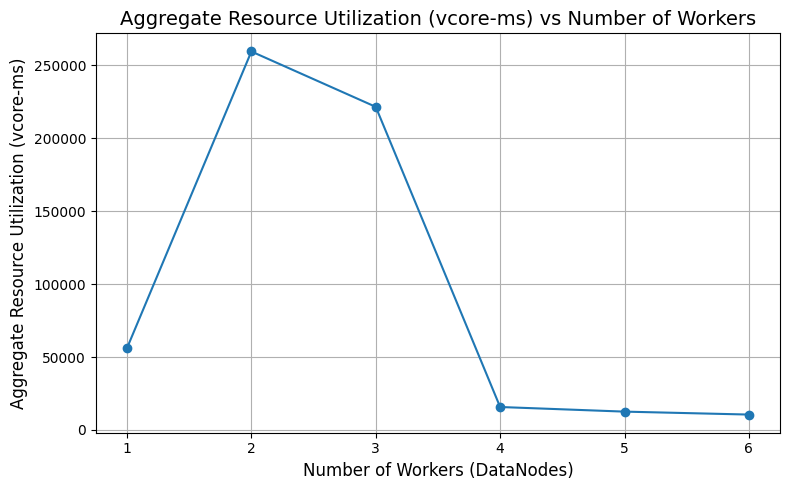

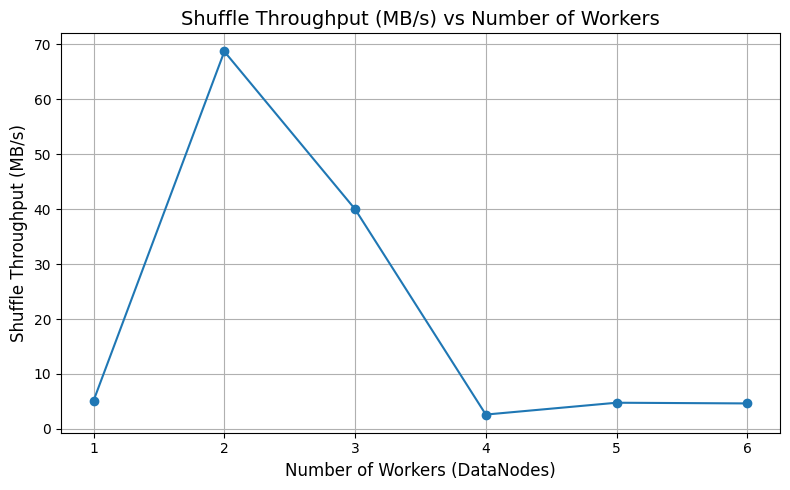

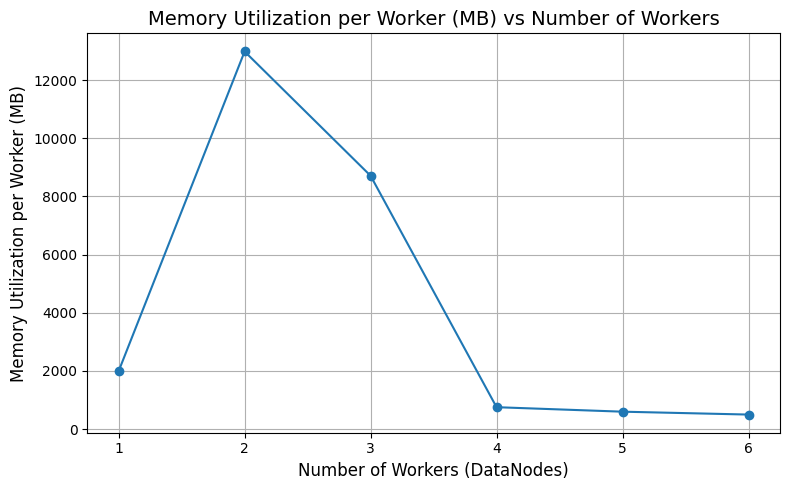

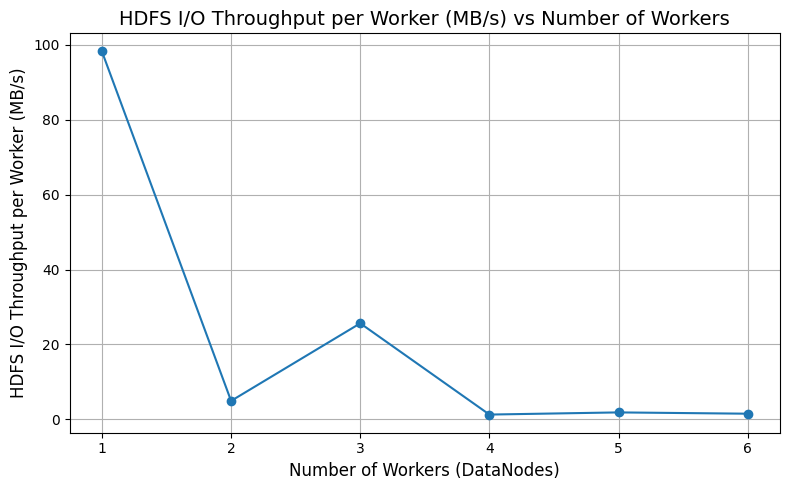

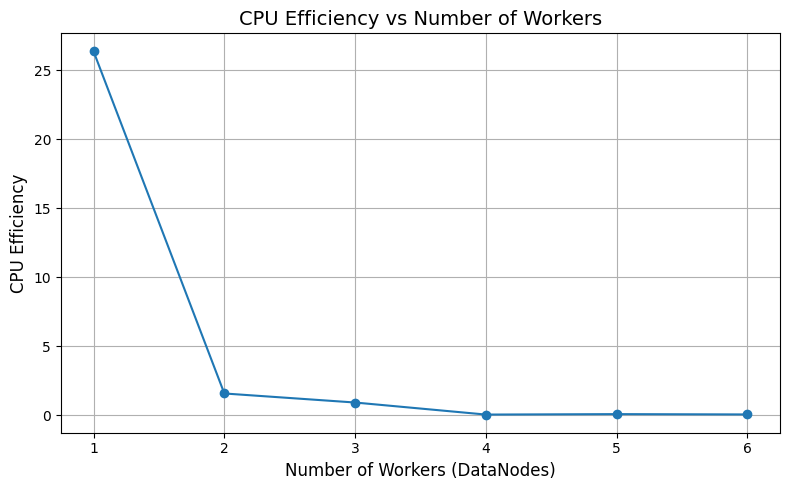

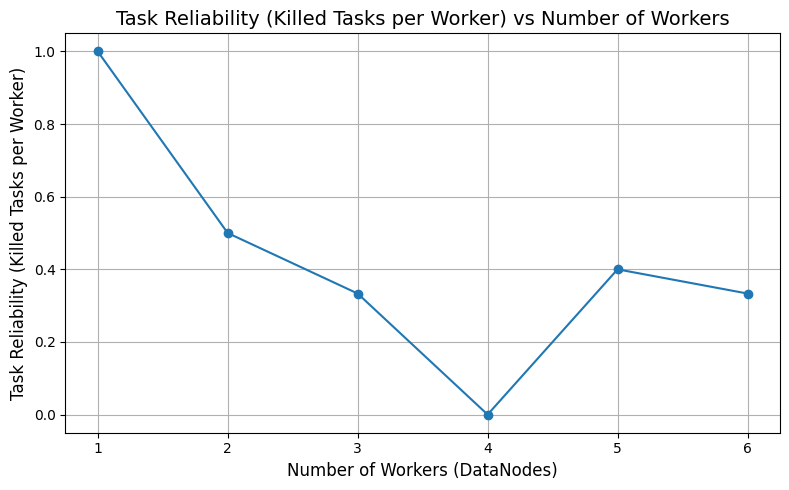

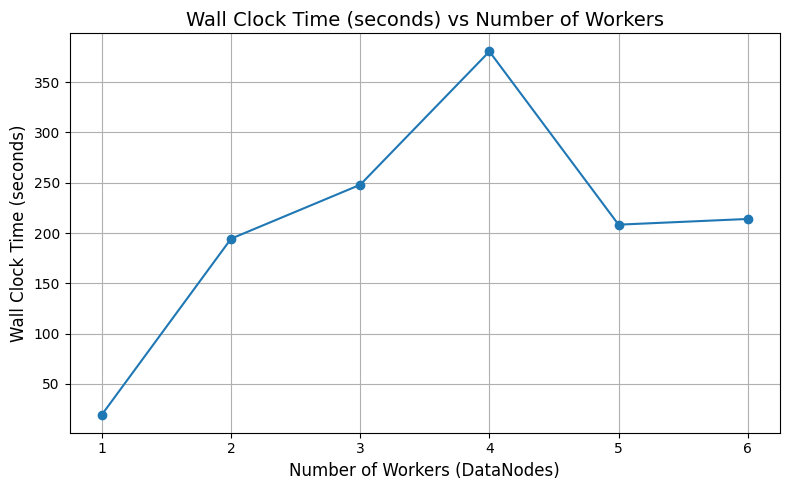

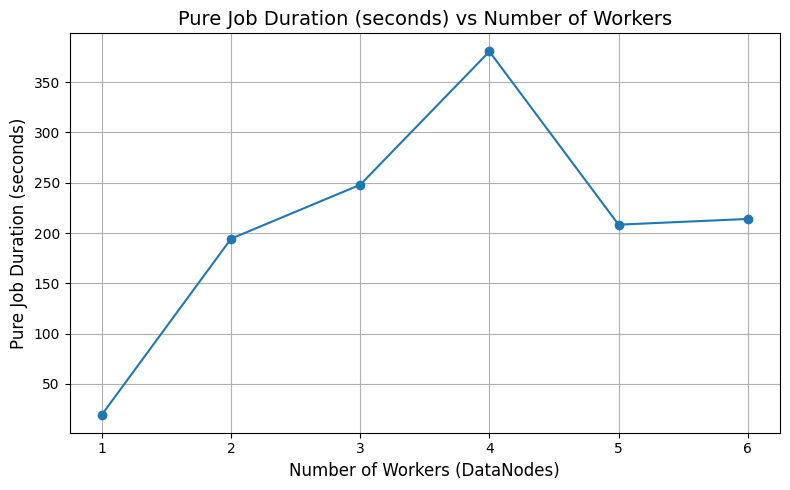

In [7]:
# Plots
metrics = [
    'agg_resource_util',
    'shuffle_throughput',
    'mem_util',
    'io_throughput',
    'cpu_efficiency',
    'task_reliability',
    'wall_time',
    'pure_job_duration'
]

titles = {
    'agg_resource_util': 'Aggregate Resource Utilization (vcore-ms)',
    'shuffle_throughput': 'Shuffle Throughput (MB/s)',
    'mem_util': 'Memory Utilization per Worker (MB)',
    'io_throughput': 'HDFS I/O Throughput per Worker (MB/s)',
    'cpu_efficiency': 'CPU Efficiency',
    'task_reliability': 'Task Reliability (Killed Tasks per Worker)',
    'wall_time': 'Wall Clock Time (seconds)',
    'pure_job_duration': 'Pure Job Duration (seconds)'
}

for metric in metrics:
    plt.figure(figsize=(8,5))
    plt.plot(hadoop_df['num_workers'], hadoop_df[metric], marker='o', linestyle='-')
    plt.title(f"{titles[metric]} vs Number of Workers", fontsize=14)
    plt.xlabel('Number of Workers (DataNodes)', fontsize=12)
    plt.ylabel(titles[metric], fontsize=12)
    plt.grid(True)
    plt.xticks(hadoop_df['num_workers'])
    plt.tight_layout()
    plt.show()

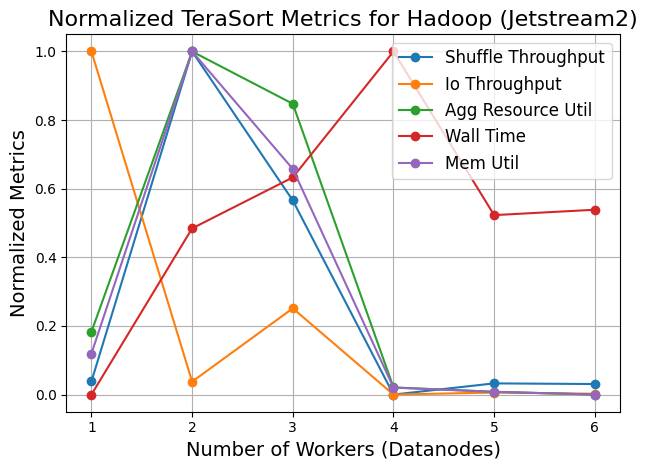

In [8]:
from sklearn.preprocessing import MinMaxScaler

# Metrics to normalize and plot
metrics_to_normalize = [
    'shuffle_throughput',
    'io_throughput',
    'agg_resource_util',
    'wall_time',
    'mem_util'
]

# Normalize the selected metrics
scaler = MinMaxScaler()
normalized_metrics = scaler.fit_transform(hadoop_df[metrics_to_normalize])

# new DataFrame for plotting
normalized_df = pd.DataFrame(
    normalized_metrics,
    columns=metrics_to_normalize
)
normalized_df['num_workers'] = hadoop_df['num_workers'].values

# Plot

for metric in metrics_to_normalize:
    plt.plot(normalized_df['num_workers'], normalized_df[metric], marker='o', label=metric.replace('_', ' ').title())

plt.title('Normalized TeraSort Metrics for Hadoop (Jetstream2)', fontsize=16)
plt.xlabel('Number of Workers (Datanodes)', fontsize=14)
plt.ylabel('Normalized Metrics', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(normalized_df['num_workers'])  # Make x-ticks exactly 1,2,3,...
plt.tight_layout()
plt.show()

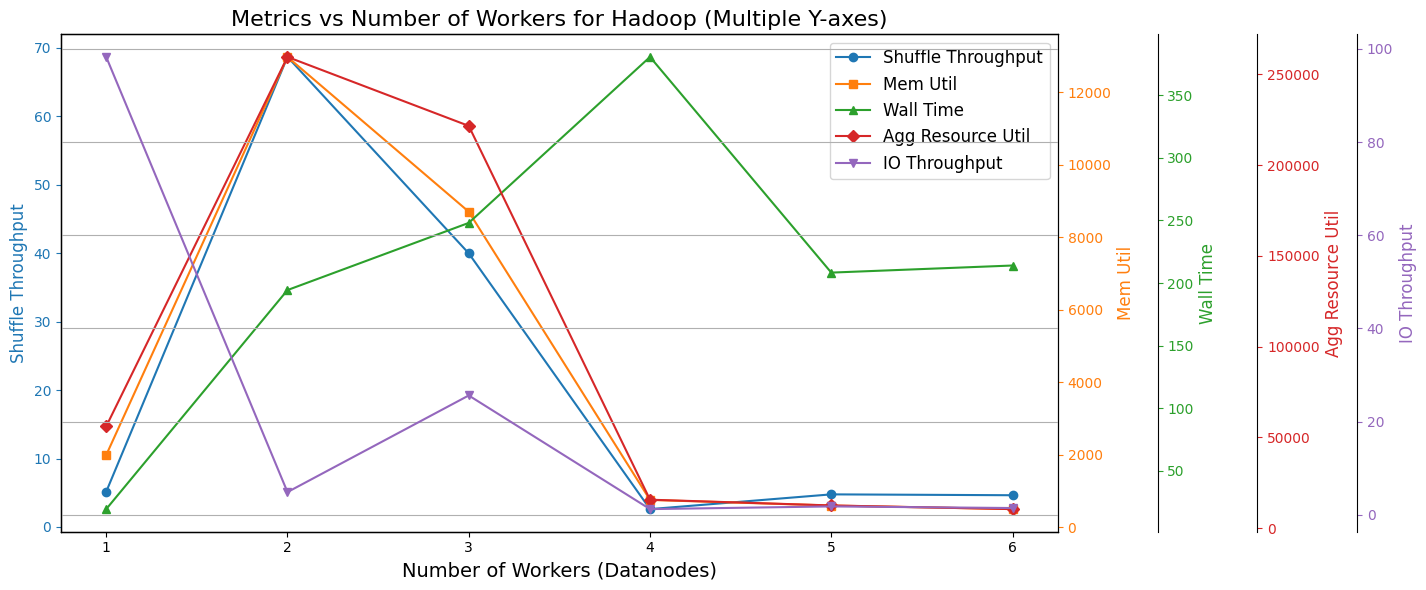

In [9]:
#Multiple y-axis plots
metrics = [
    'shuffle_throughput',
    'io_throughput',
    'agg_resource_util',
    'wall_time',
    'mem_util'
]

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

fig, host = plt.subplots(figsize=(14,6))
fig.subplots_adjust(right=0.75)

# Additional y-axes
par1 = host.twinx()
par2 = host.twinx()
par3 = host.twinx()
par4 = host.twinx()

# Offset the right spine of par2, par3, par4
par2.spines["right"].set_position(("axes", 1.1))
par3.spines["right"].set_position(("axes", 1.2))
par4.spines["right"].set_position(("axes", 1.3))

# Make spines visible
for ax in [par2, par3, par4]:
    ax.spines["right"].set_visible(True)

# Plotting
p1, = host.plot(hadoop_df['num_workers'], hadoop_df['shuffle_throughput'], color=colors[0], marker='o', label="Shuffle Throughput")
p2, = par1.plot(hadoop_df['num_workers'], hadoop_df['mem_util'], color=colors[1], marker='s', label="Mem Util")
p3, = par2.plot(hadoop_df['num_workers'], hadoop_df['wall_time'], color=colors[2], marker='^', label="Wall Time")
p4, = par3.plot(hadoop_df['num_workers'], hadoop_df['agg_resource_util'], color=colors[3], marker='D', label="Agg Resource Util")
p5, = par4.plot(hadoop_df['num_workers'], hadoop_df['io_throughput'], color=colors[4], marker='v', label="IO Throughput")

# Set labels
host.set_xlabel("Number of Workers (Datanodes)", fontsize=14)
host.set_ylabel("Shuffle Throughput", fontsize=12, color=colors[0])
par1.set_ylabel("Mem Util", fontsize=12, color=colors[1])
par2.set_ylabel("Wall Time", fontsize=12, color=colors[2])
par3.set_ylabel("Agg Resource Util", fontsize=12, color=colors[3])

par4.set_ylabel("IO Throughput", fontsize=12, color=colors[4])

# Match colors to axes
host.yaxis.label.set_color(colors[0])
par1.yaxis.label.set_color(colors[1])
par2.yaxis.label.set_color(colors[2])
par3.yaxis.label.set_color(colors[3])
par4.yaxis.label.set_color(colors[4])

# Ticks color
host.tick_params(axis='y', colors=colors[0])
par1.tick_params(axis='y', colors=colors[1])
par2.tick_params(axis='y', colors=colors[2])
par3.tick_params(axis='y', colors=colors[3])
par4.tick_params(axis='y', colors=colors[4])

# Legend
lines = [p1, p2, p3, p4, p5]
host.legend(lines, [l.get_label() for l in lines], loc='upper right', fontsize=12)


plt.title('Metrics vs Number of Workers for Hadoop (Multiple Y-axes)', fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.show()